# **Point Net for Segmentation**

This notebook will explore the Segmentation head of Point Net using the reduced and paritioned version of S3DIS dataset. This version is similar to the one used by torch geometry except that we will have to normalize and sample data on the fly. 

In [1]:
import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

Initialize variables for entire notebook

In [3]:
# dataset
ROOT = r'C:\Users\itber\Documents\datasets\S3DIS\Stanford3dDataset_v1.2_Reduced_Partitioned_Aligned_Version_1m'

# feature selection hyperparameters
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 15000

BATCH_SIZE = 16

See: https://www.mathworks.com/help/vision/ug/point-cloud-classification-using-pointnet-deep-learning.html

In [4]:
CATEGORIES = {
    'ceiling'  : 0, 
    'floor'    : 1, 
    'wall'     : 2, 
    'beam'     : 3, 
    'column'   : 4, 
    'window'   : 5,
    'door'     : 6, 
    'table'    : 7, 
    'chair'    : 8, 
    'sofa'     : 9, 
    'bookcase' : 10, 
    'board'    : 11,
    'stairs'   : 12,
    'clutter'  : 13
}

# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # ceiling - darkslategray
    1  : (139, 69, 19),   # floor - saddlebrown
    2  : (34, 139, 34),   # wall - forestgreen
    3  : (75, 0, 130),    # beam - indigo
    4  : (255, 0, 0),     # column - red 
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}

v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

#### Get Datasets and Dataloaders

In [7]:
from torch.utils.data import DataLoader
from s3dis_dataset import S3DIS

# get datasets
s3dis_train = S3DIS(ROOT, area_nums='1-4', npoints=NUM_TRAIN_POINTS, r_prob=0.25)
s3dis_valid = S3DIS(ROOT, area_nums='5', npoints=NUM_TRAIN_POINTS, r_prob=0.)
s3dis_test = S3DIS(ROOT, area_nums='6', split='test', npoints=NUM_TEST_POINTS)

# get dataloaders
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

Get an example and display it

In [6]:
points, targets = s3dis_train[1000]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

#### Investigate class distributions in the Training dataset

NOTE: If you take a look at the S3DIS dataset class, you will notice that samples with less points than npoints are sampled with replacement. This means that some points will be oversampled. This will lead to a variable class balance eachtime the dataloader is called. However, you can run these cells many times and see that we will nearly always have the same ratios of classes.

In [ ]:
total_train_targets = []
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

Plot Barchart of category counts

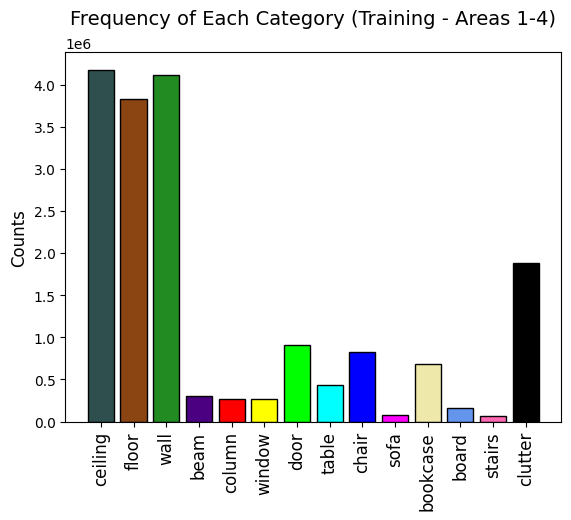

In [8]:
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Frequency of Each Category (Training - Areas 1-4)', size=14, pad=20);

We can see that this dataset is heavily imbalanced, the more common items such as ceiling, floor, and wall greatly outnumber all of the other categories. These classes are actually background classes. If we were to train using a loss such as Cross Entropy, we would consider each class to have an equal importance. Meaning, missclassifyng window is treated the same as misclassifying wall. In reality, we would want our model to focus more on the uncommon categories and not care so much about the common ones. We have a priori knowledge that structures such as ceiling, wall, and floor are continuous and if we look at some training examples, we will see that they are like large sheets. If we were to only classify 60% of these, we would still be in pretty good shape. However, if we classify only 60% of the other less common classes, we may run into some serious generalization issues. One way to overcome the class imbalance is to use a weighted loss function. This will essentially tell the model (during training) to focus more on particular classes that it gets wrong (hard examples) and to focus less on the classes it tends to get right (easy examples).

The loss that we will use is based off of the [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf), which is a modified version of the Cross Entropy (CE) loss that is useful for imbalanced classification, it focuses the training on a sparse set of hard examples. 

We will also add the [Dice Loss](https://arxiv.org/pdf/1707.03237v3.pdf) to improve the IOU performance. See also this [paper](https://www.sciencedirect.com/science/article/pii/S2590005619300049#bib72) for Dice Loss. See [wiki](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)

Point Net Segmentation Loss:

$$ FL(p_n) = -\alpha_{y_n} (1 - p_n)^\gamma log(p_n)  $$
$$ DL(p_n) = 1 - 2\frac{|y_n \cap p_n|}{|y_n| + |p_n|} $$

$$ \mathcal{L(p_n)} = FL(p_n) + DL(p_n) $$

### Get Segmentation Version of Point Net
Make a test forward pass

In [8]:
from point_net import PointNetSegHead

points, targets = next(iter(train_dataloader))

In [9]:
from point_net import PointNetSegHead

points, targets = next(iter(train_dataloader))

seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([16, 4096, 14])


## Start Training

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

Compute $\alpha$ as the normalized inverse class frequency.

Instead compute alpha roughly based on class frequencies

Load model from disk if necessary

In [11]:
# MODEL_PATH = 'seg_balanced/seg_model_15.pth'

# seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES).to(DEVICE)
# seg_model.load_state_dict(torch.load(MODEL_PATH))

#### Training hyperparameters

In [12]:
import torch.optim as optim
from point_net_loss import PointNetSegLoss

EPOCHS = 100
LR = 0.0001

# use inverse class weighting
# alpha = 1 / class_bins
# alpha = (alpha/alpha.max())

# manually set alpha weights
alpha = np.ones(len(CATEGORIES))
alpha[0:3] *= 0.25 # balance background classes
alpha[-1] *= 0.75  # balance clutter class

gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-3, 
                                              step_size_up=1000, cycle_momentum=False)
criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(DEVICE)

seg_model = seg_model.to(DEVICE)

For our training we will want to quantify how well our model is performing. Typically we look at loss and accuracy, but for this segmentation problem we will need a metric that accounts for incorrect classification as well as correct classification. The Matthews Correlation Coefficient does this and we will use it to quantify our performance. The MCC ranges from -1 to 1, to understand what the MCC is reporting:
- 0 indicates a random guess
- -1 is the worst possible performance
- 1 is the best possible performance

In [13]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

We also want to track how well the models learns structure, so we will keep track of the IOU

In [14]:
def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [13]:
# store best validation iou
best_iou = 0.6
best_mcc = 0.6

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

In [14]:
# stuff for training
num_train_batch = int(np.ceil(len(s3dis_train)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(s3dis_valid)/BATCH_SIZE))

for epoch in range(1, EPOCHS + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, _ = seg_model(points)

        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # get loss and perform backprop
        loss = criterion(preds, targets, pred_choice) 
        loss.backward()
        optimizer.step()
        scheduler.step() # update learning rate
        
        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        _valid_iou = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.squeeze().to(DEVICE)

            preds, _, A = seg_model(points)
            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

            loss = criterion(preds, targets, pred_choice) 

            # get metrics
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)
            iou = compute_iou(targets, pred_choice)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())
            _valid_iou.append(iou.item())

            if i % 100 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                  + f'valid loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} '
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        valid_iou.append(np.mean(_valid_iou))
        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
              + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
              + f'- Valid IOU: {valid_iou[-1]:.4f}')


        # pause to cool down
        time.sleep(4)

    # save best models
    if valid_iou[-1] >= best_iou:
        best_iou = valid_iou[-1]
        torch.save(seg_model.state_dict(), f'trained_models/seg_focal_dice_iou_rot_clr/seg_model_{epoch}.pth')

    # if valid_mcc[-1] >= best_mcc:
    #     best_mcc = valid_mcc[-1]
    #     torch.save(seg_model.state_dict(), f'trained_models/seg_focal_dice_mcc/seg_model_{epoch}.pth')

	 [1: 0/275] train loss: 3.5263 accuracy: 0.0703 mcc: -0.0041 iou: 0.0364
	 [1: 100/275] train loss: 3.3909 accuracy: 0.1211 mcc: 0.0046 iou: 0.0644
	 [1: 200/275] train loss: 2.1073 accuracy: 0.5023 mcc: 0.3770 iou: 0.3354
Epoch: 1 - Train Loss: 2.8462 - Train Accuracy: 0.2748 - Train MCC: 0.1684 - Train IOU: 0.1707
	 [1: 0/146] valid loss: 1.6036 accuracy: 0.5924 mcc: 0.4717 iou: 0.4209
	 [1: 100/146] valid loss: 1.9401 accuracy: 0.5160 mcc: 0.3752 iou: 0.3477
Epoch: 1 - Valid Loss: 2.0993 - Valid Accuracy: 0.5050 - Valid MCC: 0.3812 - Valid IOU: 0.3410
	 [2: 0/275] train loss: 2.4266 accuracy: 0.3592 mcc: 0.2405 iou: 0.2189
	 [2: 100/275] train loss: 1.5826 accuracy: 0.5526 mcc: 0.4692 iou: 0.3818
	 [2: 200/275] train loss: 1.2591 accuracy: 0.6513 mcc: 0.5661 iou: 0.4829
Epoch: 2 - Train Loss: 1.6531 - Train Accuracy: 0.5538 - Train MCC: 0.4511 - Train IOU: 0.3865
	 [2: 0/146] valid loss: 1.6850 accuracy: 0.5303 mcc: 0.4465 iou: 0.3609
	 [2: 100/146] valid loss: 1.2291 accuracy: 0.6

#### plot the training metrics

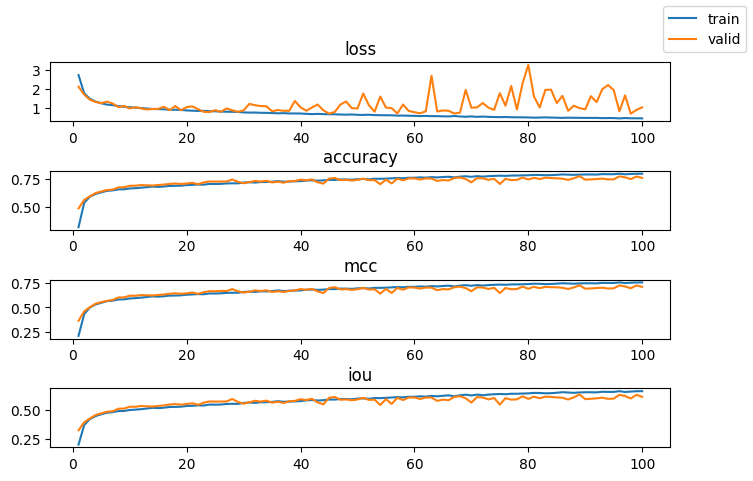

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(8, 5))
ax[0].plot(np.arange(1, EPOCHS + 1), train_loss, label='train')
ax[0].plot(np.arange(1, EPOCHS + 1), valid_loss, label='valid')
ax[0].set_title('loss')

ax[1].plot(np.arange(1, EPOCHS + 1), train_accuracy)
ax[1].plot(np.arange(1, EPOCHS + 1), valid_accuracy)
ax[1].set_title('accuracy')

ax[2].plot(np.arange(1, EPOCHS + 1), train_mcc)
ax[2].plot(np.arange(1, EPOCHS + 1), valid_mcc)
ax[2].set_title('mcc')

ax[3].plot(np.arange(1, EPOCHS + 1), train_iou)
ax[3].plot(np.arange(1, EPOCHS + 1), valid_iou)
ax[3].set_title('iou')

fig.legend(loc='upper right')
plt.subplots_adjust(wspace=0., hspace=0.85)

### Test the model

In [15]:
MODEL_PATH = 'trained_models/seg_focal_dice_iou_rot/seg_model_68.pth'

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

#### Implement Quick test to gather metrics

In [17]:
num_test_batch = int(np.ceil(len(s3dis_test)/BATCH_SIZE))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        preds, _, A = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        loss = criterion(preds, targets, pred_choice)

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

	 [0/72] test loss: 0.2122 accuracy: 0.8811 mcc: 0.8561 iou: 0.7874
	 [50/72] test loss: 0.6016 accuracy: 0.7534 mcc: 0.7164 iou: 0.6044


In [18]:
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

Test Loss: 0.6104 - Test Accuracy: 0.7505 - Test MCC: 0.7056 - Test IOU: 0.6086


In [ ]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

#### Get Confusion Matrix for Test data

In [ ]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

,ceiling,floor,wall,beam,column,window,door,table,chair,sofa,bookcase,board,stairs,clutter
ceiling,3545248,3674,50056,2181,16,695,2943,0,0,0,411,0,411,148354
floor,9862,3258788,10330,0,555,0,2296,19,81,0,9,0,4,297
wall,112543,31086,2818139,7281,16350,85341,425939,6232,2213,0,22102,3647,3910,86794
beam,73315,0,78679,345220,626,0,78456,0,0,0,4860,0,0,120937
column,3416,8071,229207,22,103106,1409,92291,211,835,0,10723,0,0,44349
window,2277,69,74805,0,0,272191,0,4,20,0,0,0,0,3657
door,0,19906,215755,8584,12627,0,628925,404,1122,0,3636,0,0,22004
table,0,22171,44481,0,1914,1362,9758,448374,150737,5771,19454,0,0,72332
chair,0,59108,7442,0,1079,0,15119,52734,501930,5062,1242,113,50,18633
sofa,0,7298,1045,0,0,0,226,4609,32774,9660,3134,72,0,13029


#### View test results on full space

In [21]:
torch.cuda.empty_cache() # release GPU memory
points, targets = s3dis_test.get_random_partitioned_space()

# place on device
points = points.to(DEVICE)
targets = targets.to(DEVICE)

# Normalize each partitioned Point Cloud to (0, 1)
norm_points = points.clone()
norm_points = norm_points - norm_points.min(axis=1)[0].unsqueeze(1)
norm_points /= norm_points.max(axis=1)[0].unsqueeze(1)

with torch.no_grad():

    # prepare data
    norm_points = norm_points.transpose(2, 1)
    targets = targets.squeeze()

    # run inference
    preds, _, _ = model(norm_points)

    # get metrics
    pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

    loss = criterion(preds, targets, pred_choice)
    correct = pred_choice.eq(targets.data).cpu().sum()
    accuracy = correct/float(points.shape[0]*NUM_TEST_POINTS)
    mcc = mcc_metric(preds.transpose(2, 1), targets)
    iou = compute_iou(targets, pred_choice)

print(f'Loss: {loss:.4f} - Accuracy: {accuracy:.4f} - MCC: {mcc:.4f} - IOU: {iou:.4f}')

Loss: 0.4256 - Accuracy: 0.8052 - MCC: 0.7692 - IOU: 0.6739


Display the truth and predictions

In [22]:
# display true full point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_1')

OPTIONAL: Save point cloud

In [24]:
o3.io.write_point_cloud('full.pcd', pcd)

True

In [25]:
# display true partitioned point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[2, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.to('cpu')[2, :])).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

In [26]:
# display predicted full point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_2')

In [27]:
o3.io.write_point_cloud('full_predicted.pcd', pcd)

True

In [ ]:
# display predicted partitioned point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[2, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.to('cpu')[2, :])).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

Try displaying both point clouds??

In [81]:
# display true full point cloud
pcd_1 = o3.geometry.PointCloud()
pcd_1.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd_1.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.reshape(-1).to('cpu'))).T/255)

# display predicted full point cloud
pcd_2 = o3.geometry.PointCloud()
pcd_2.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T + torch.Tensor([5, 0, 0]))
pcd_2.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.reshape(-1).to('cpu'))).T/255)

draw([pcd_1] + [pcd_2])

WebVisualizer(window_uid='window_11')

### Inspect the critical indexes

In [28]:
torch.cuda.empty_cache() # release GPU memory
points, targets = s3dis_test.get_random_partitioned_space()

# place on device
points = points.to(DEVICE)
targets = targets.to(DEVICE)

# Normalize each partitioned Point Cloud to (0, 1)
norm_points = points.clone()
norm_points = norm_points - norm_points.min(axis=1)[0].unsqueeze(1)
norm_points /= norm_points.max(axis=1)[0].unsqueeze(1)

with torch.no_grad():

    # prepare data
    norm_points = norm_points.transpose(2, 1)
    targets = targets.squeeze()

    # run inference to get critical indexes
    _, crit_idxs, _ = model(norm_points)

### Aggregate data into single point clouds

In [50]:
pcds = []
crit_pcds = []
for i in range(points.shape[0]):
    
    pts = points[i, :]
    cdx = crit_idxs[i, :]
    tgt = targets[i, :]

    # get full point clouds
    pcd = o3.geometry.PointCloud()
    pcd.points = o3.utility.Vector3dVector(pts)
    pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(tgt)).T/255)

    # get critical set point clouds
    critical_points = pts[cdx, :]
    critical_point_colors = np.vstack(v_map_colors(tgt[cdx])).T/255

    crit_pcd = o3.geometry.PointCloud()
    crit_pcd.points = o3.utility.Vector3dVector(critical_points)
    crit_pcd.colors = o3.utility.Vector3dVector(critical_point_colors)

    pcds.append(pcd)
    crit_pcds.append(crit_pcd)

In [51]:
draw(pcds)

WebVisualizer(window_uid='window_7')

In [49]:
# save
pcds_combined = pcds[0]
for p in pcds[1:]:
    pcds_combined += p

o3.io.write_point_cloud('full_set.pcd', pcds_combined)

True

#### Draw critical indexes of a single partition

In [29]:
pts = points[0, :].to('cpu')
cdx = crit_idxs[0, :].to('cpu')
tgt = targets[0, :].to('cpu')

In [30]:
critical_points = pts[cdx, :]
critical_point_colors = np.vstack(v_map_colors(tgt[cdx])).T/255

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(critical_points)
pcd.colors = o3.utility.Vector3dVector(critical_point_colors)

# o3.visualization.draw_plotly([pcd])
# draw(pcd, point_size=5) # does not work in Colab
draw(pcd)

WebVisualizer(window_uid='window_3')

#### Draw Critical Indexes of the entire Space

In [53]:
draw(crit_pcds, point_size=5)

WebVisualizer(window_uid='window_9')

In [35]:
# save
pcds_combined = pcds[0]
for p in pcds[1:]:
    pcds_combined += p

o3.io.write_point_cloud('critical_set.pcd', pcds_combined)